In [2]:
pts1 = [12,13,14,15,16,1,1,2,4]
pts1.pop(2)
print(pts1)

[12, 13, 15, 16, 1, 1, 2, 4]


In [5]:
masks = []
masks.append(1)
print(masks)

[1]


In [17]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
import extcolors
import skimage
import scipy
from PIL import Image
import math
import skimage
from sklearn.linear_model import LinearRegression
import pandas as pd
from colormap import rgb2hex
import numpy as np
import cv2
import os


VID = 0
SING_IMG = 1
nb_row = 4

# READ AND NORMALIZE IMAGES
def obtain_name_images(image_folder):
    """
    input : name of the folder with the images
    output : name of the files to be open
    """
    lst = os.listdir(image_folder)
    lst.sort()
    name_images = [img for img in lst 
                if img.endswith(".jpg") or
                    img.endswith(".jpeg") or
                    img.endswith(".JPG") or
                    img.endswith("png")]

    return name_images 

def obtain_images(name_images, image_folder, mode):
    """
    input : name and foler of the images location
    returns : list containing all the images in the folder in RGB format
    """
    imgs = []
    if mode == VID : 
        for idx, name in enumerate(name_images):
            img = cv2.imread(os.path.join(image_folder, name))
            if img is not None : 
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                if (idx!=0): 
                    img_small = img_resize(img_rgb, output_width = 500)#, output_width=imgs[0].shape[0])
                if(idx==0) : 
                    img_small = img_resize(img_rgb, output_width = 500)#, output_width=img.shape[0])
                imgs.append(img_small)

    if mode == SING_IMG :
        print('image read : ', os.path.join(image_folder, name_images))
        img = cv2.imread(os.path.join(image_folder, name_images))
        if img is not None : 
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_small = img_resize(img_rgb, output_width=320)#320)
            imgs.append(img_small)
        else : 
            print('no image read')

    if (len(imgs) != 0) : 
        return imgs #return rgb img
    
    return None

def img_resize(img, output_width = 900):
    """
    input : image
    output : resized image
    """
    wpercent = (output_width/float(img.shape[1]))
    hsize = int((float(img.shape[0])*float(wpercent)))
    img = cv2.resize(img, (output_width,hsize), interpolation = cv2.INTER_AREA) 
    #this resize makes the video not work??
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def colors_to_array(colors_x) : 
    """
    input : tuple containing list of the main colors cluster of the images
    output : 2 np array containg the cluster color in rgb and lab space
    """
    colors_rgb = np.zeros((len(colors_x[0]),3))
    colors_lab = np.zeros((len(colors_x[0]),3))

    for i in range(len(colors_x[0])):
        col = colors_x[0][i][0]
        colors_rgb[i] = col
        colors_lab[i] = skimage.color.rgb2lab((col[0]/255, col[1]/255, col[2]/255))

    return colors_rgb, colors_lab

def donuts(colors_x): 
    """
    input : tuple containing list of the main colors cluster of the images and their occurence
    output : plt figure reprensenting the main colors anf their proportions
    """
    colors_pre_list = str(colors_x).replace('([(','').split(', (')[0:-1]
    df_rgb = [i.split('), ')[0] + ')' for i in colors_pre_list]
    df_percent = [i.split('), ')[1].replace(')','') for i in colors_pre_list]
    
    #convert RGB to HEX code
    df_color_up = [rgb2hex(int(i.split(", ")[0].replace("(","")),
                          int(i.split(", ")[1]),
                          int(i.split(", ")[2].replace(")",""))) for i in df_rgb]
    
    df_color = pd.DataFrame(zip(df_color_up, df_percent), columns = ['c_code','occurence'])
    list_color = list(df_color['c_code'])
    list_precent = [int(i) for i in list(df_color['occurence'])]
    text_c = [c + ' ' + str(round(p*100/sum(list_precent),1)) +'%' 
            for c, p in zip  (list_color, list_precent)]
    fig, ax = plt.subplots(figsize=(50,50),dpi=10)
    wedges, text = ax.pie(list_precent,
                        labels= text_c,
                        labeldistance= 1.05,
                        colors = list_color,
                        textprops={'fontsize': 120, 'color':'black'}
                        )
    plt.setp(wedges, width=0.3)

    #create space in the center
    plt.setp(wedges, width=0.36)

    ax.set_aspect("equal")
    fig.set_facecolor('white')
    plt.show()  

def extract_rgb_colors(img):
    """
    input : rgb image as np array
    output : list of main rgb colors 
    """
    # extract the main colors from the image 
    im_pil = Image.fromarray(img)
    colors_x = extcolors.extract_from_image(im_pil, tolerance = 12, limit = 8)# before limit 8 
    colors_rgb, colors_lab = colors_to_array(colors_x)
    #donuts(colors_x)# for debugging 

    return colors_rgb

def greenest_color(colors_rgb):
    """
    input : list of rgb colors
    output : greenest color in rgb format
    """
    diff = smallest_diff = float('inf')

    for col in colors_rgb:
        # calculate the difference to the green
        diff = np.linalg.norm(np.asarray(col - [0,255,0])) # maybe better to use lab format?
        if diff < smallest_diff: # if closest to green
            smallest_diff =diff
            col_best_mask = col
    col_best_mask = col_best_mask.astype(int)
    r,g,b = (col_best_mask.data)
    
    print('the best color is : rgb ', col_best_mask, 'hex : ', rgb2hex(r,g,b))

    return col_best_mask

def mask_vegetation(img_lab, col_lab):
    """
    input : 
    output :
    """
    # Using inRange method, to create a mask
    thr = [8,8,8] # 4,4,4 for vid? before : 8 20 8 , TODO : maybe change  thr according to histogram ??
    lower_col = col_lab - thr
    upper_col = col_lab + thr
    mask = cv2.inRange(img_lab, lower_col, upper_col)
    return mask

def veg_segmentation(img, img_no_sky):

    # extract the main colors from the image 
    colors_rgb = extract_rgb_colors(img)

    # extract greenest color 
    col_best_mask = greenest_color(colors_rgb)

    # convert color and image to lab space
    img_lab = skimage.color.rgb2lab(img_no_sky/255)
    col_best_mask_lab = skimage.color.rgb2lab((col_best_mask[0]/255, col_best_mask[1]/255, col_best_mask[2]/255))

    # vegetation segmentation using mask of the detected vegetal color
    best_mask = mask_vegetation(img_lab, col_best_mask_lab)

    best_mask_median = cv2.medianBlur(best_mask,3)
    
    return best_mask_median, best_mask, col_best_mask

def hough_line_improved(mask, angle_acc):
    """
    input : 2D mask + list containing the angle previously found
    output : accumulator + array to convert theta and rhos to accumulator coordinates
    """
    # Rho and Theta ranges
    thetas = np.deg2rad(np.arange(0, 180))
    width, height = mask.shape
    diag_len = int(np.ceil(np.sqrt(width * width + height * height)))   # max_dist
    rhos = np.linspace(-diag_len, diag_len, num = diag_len * 2)

    # Cache some resuable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint64)
    acc_bis = np.zeros((2 * diag_len, num_thetas), dtype=np.uint64)
    #acc_bis = np.zeros((2 * diag_len, num_thetas), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(mask)  # (row, col) indexes to edges

    # Vote in the hough accumulator
    for i in range(len(x_idxs)):
        #print('step ', i, 'of len ', len(x_idxs))
        x = x_idxs[i]
        y = y_idxs[i]

        for t_idx in range(num_thetas):
            # Calculate rho. diag_len is added for a positive index
            rho = round(x * cos_t[t_idx] + y * sin_t[t_idx]) + diag_len
            accumulator[rho, t_idx] += 1
            acc_bis[rho, t_idx] += 1
            if (abs(np.rad2deg(thetas[t_idx])-90)<25): #if horizontale lignes 
                accumulator[:, t_idx] = 0
            
            for angle in angle_acc:
                if (abs(np.rad2deg(thetas[t_idx])-np.rad2deg(angle))<10): #if angle already detected 
                    accumulator[:, t_idx] = 0
    
    #acc_new = cv2.normalize(acc_bis, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    #cv2.imshow('acc bis ', acc_new) #cv2.convertScaleAbs(acc, alpha=1.0/256.0))
    #cv2.waitKey(0)
    return accumulator, thetas, rhos, acc_bis

def check_outliers_crop(pts1,pts2, th_acc, r_acc):

    print('check outliers crop function here')

    return pts1,pts2, th_acc, r_acc

def VP_detection(th_acc, r_acc, threshold_acc, stage ): 
    #stage = 0 for ini process, 1 for speed process
    #VP detection 
    #ADD COND THAT INTERSEECTON MUST BE IN A RADIUS TO AVOID OUTLIERS 
    # => or KMEAN with K = 2?
    # ceci arrondi vers le bas

    A = B = C = D = E = 0
    #V = threshold_acc.sum()
    V = sum(threshold_acc)
    idx_outlier = None 
    outlier = None

    for t,r,w in zip(th_acc, r_acc, threshold_acc):
        a = np.cos(t)
        b = np.sin(t)
        A = A + w*pow(a,2)
        B = B + w*pow(b,2)
        C = C + w*a*b
        D = D + w*a*r
        E = E + w*b*r
        #print(a,b,A,B,C,D,E)

    M = np.array([[A,C],[C,B]])
    #print(np.linalg.det(M))
    b = np.array([D,E])
    if(np.linalg.det(M)!=0): 
        x0,y0 = np.linalg.solve(M,b).astype(int)
    else : 
        x0 = y0 = 0
        print('sing matrix ')
    
    if (stage==0):
        #print('check outliers')
        var_residual = 0
        eps_acc = []
        for t,r,w in zip(th_acc, r_acc, threshold_acc):
            #p avec w --> here is not devided by V on  oth size, need to nnormalize it  
            eps = r - (x0*np.cos(t) + y0 * np.sin(t)) #fct of 
            eps_acc.append(abs(eps))
            var_residual = var_residual + (w/V)*pow(eps,2) #est ce que on veut vraiment prendre le w? 
            # peut eetre que toutes les lignes deraient etre considere de la meme importance
            #print('\n eps : ', eps, 'estimates rho : ', (x0*np.cos(t) + y0 * np.sin(t)), 'rho : ', r, 'var residual : ', var_residual)

        var_residual = np.sqrt(var_residual)
        #print('var res : ', var_residual)
        eps_max = max(eps_acc)
        print('is it outlier = eps max, var', eps_max, var_residual)
        idx_max = eps_acc.index(eps_max)
        if ((eps_max>1.25*var_residual) and (eps_max>20)):
            #print('outlier : ', idx_max, eps_max )
            idx_outlier = idx_max
            outlier = [idx_outlier, th_acc[idx_outlier], r_acc[idx_outlier]]
            #print(eps_max, var_residual)

    
    #print('VP : ', x0, y0)

    return ((x0+1),y0), outlier #x0 + 1

def apply_ransac(img_no_sky, masked_images_i, vp_point, vp_on, best_mask, arr_mask_i, i):

    #print('i in apply ransac : ', i)
    mask_single_crop = np.zeros_like(img_no_sky)
    x,y = np.where(masked_images_i>0)
    data = np.column_stack([x, y])
    if(vp_on>0):
        vp_point = np.asarray(vp_point)
        n = int(data.shape[0])
        vp_data_x = np.full((n,1), vp_point[1])
        vp_data_y = np.full((n,1), vp_point[0])
        data_vp = np.column_stack([vp_data_x, vp_data_y])
        data = np.row_stack([data, data_vp])

    #INITIALIATE COND SPEED??
    cond_speed = 0

    if(data.shape[0]>700):
        data = data[np.random.choice(data.shape[0], 500, replace=False), :]

    #put condition, if data to small, go to initial process!
    if(data.shape[0]<20):
        print(' not enough data in mask : ', i)
        print(data.shape)
        #cv2.imshow('masked image i', masked_images_i)
        #cv2.imshow('best_mask', best_mask)
        #cv2.imshow('arr_mask_i', arr_mask_i)
        cond_speed = 0
        p0 = [0,0]
        p1 = [0,1]
        p2 = [0,2]
        m  = 0

    else : #(data.shape>10):
        cond_speed = 1
        model, inliers = skimage.measure.ransac(data, skimage.measure.LineModelND, min_samples=2, residual_threshold=1, max_trials=1000)
        temp = np.copy(masked_images_i)
        y0, x0 = model.params[0]#.astype(int)
        t1, t0 = model.params[1]
        m = -t1/t0
        if(m==0):
            print('slope = 0 : ', m)
        k1 = (img_no_sky.shape[0]-y0)/m
        k2 = -(y0)/m


        p2 = [int(x0 - k2), int(y0 + k2*m)]
        p0 = [int(x0),int(y0)]
        p1 = [int(x0 - k1), int(y0 + k1*m)]

        """print('\n', i, ' :  k1, k2  : ', k1, k2, 'm : ', m)
        print('x0,y0 : ', x0, y0,)
        print('x1, y1 : ', p1)
        print('x2,y2 : ', p2, '\n')"""


    return p1, p2, m, cond_speed

def remove_double(p1, p2, m, acc_m, masked_image, wd):
    cond_double = 0
    #print('in')
    #print(acc_m)
    if (len(acc_m)>=1):

        for m_others in acc_m:
            #print('diff m', m - m_others)

            if (abs(m-m_others)<0.1): #if angle already detected 
                print('pb : double detected', m, m_others)

                #cv2.line(masked_image, p1, p2, (0,0,0), wd)
                cond_double = 0
                return masked_image, cond_double
                #print('diff : ', m, m_others)
            
            else : #pas une bonne idée : une crop pourrait en remplacer une autre 
                cond_double = 1
    else : 
        cond_double = 1

    return masked_image, cond_double

def remove_horizon(p1, p2, m, masked_image, bw):
    thr = 0.2 #before : 0.1
    cond_horizon = 0

    if (abs(m)<thr):
        #cv2.line(masked_image, p1, p2, (0,0,0), bw)
        #print('horizon detected', m)
        cond_horizon = 0
        print('pb : horizon detected')


    if (abs(m)>=thr):
        cond_horizon = 1

    return masked_image, cond_horizon

def squared_distance_to_line(point, line_point1, line_point2):
    # Convert the points to numpy arrays for easier calculations
    point = np.array(point)
    line_point1 = np.array(line_point1)
    line_point2 = np.array(line_point2)

    # Calculate the direction vector of the line
    line_dir = line_point2 - line_point1

    # Calculate the normal vector of the line
    line_normal = np.array([line_dir[1], -line_dir[0]])

    # Calculate the squared distance from the point to the line by taking the dot product of the normal vector
    # with the vector pointing from the line to the point, and then dividing by the square of the length of the normal vector
    return np.dot(line_normal, point - line_point1)**2 / np.dot(line_normal, line_normal)

def pattern_ransac(arr_mask, vp_point, img, max_iterations=100, threshold=2000):

    #regarder si y a pas fonction toute faite pour trouver les difference 
    model = None 
    nb_cr = len(arr_mask)
    data = np.zeros(((nb_cr+1),2)) #+1 for the VP point 
    best_nb_inliers = 0

    for it in range(max_iterations):
        if (it%10==0):
            print('iteration ', it, ' out of ', max_iterations)
        
        list_cr_lines = []

        rand_vp = [vp_point[0] + np.random.randint(-10,10), vp_point[1] + np.random.randint(-10, 10)]

        #first randomly select data 
        data[nb_cr] = rand_vp
        for i in range(nb_cr): #select randomlw one point from each mask

            row = cv2.bitwise_and(img, arr_mask[i])
            y,x = np.where(row>0)
            rand_nb = np.random.randint(0, len(x)-1)
            data[i] = [x[rand_nb], y[rand_nb]]
            pt1 = (rand_vp[0], rand_vp[1])
            pt2 = (x[rand_nb], y[rand_nb])
            list_cr_lines.append([pt1, pt2])

        nb_inliers = 0

        
        #calculate error 
        for i in range(nb_cr):
            row = cv2.bitwise_and(img, arr_mask[i])
            x,y = np.where(row>0)
            [p1,p2] = np.array(list_cr_lines[i])

            for x_x, y_y in zip(x,y):
                p3 = np.array(x_x,y_y)
                err = squared_distance_to_line(p3, p1, p2)
                #print(err)

                if abs(err)<threshold:
                    nb_inliers = nb_inliers + 1
        

        if nb_inliers>best_nb_inliers:
            #print('new best nb inliers : ', best_nb_inliers)
            best_nb_inliers = nb_inliers
            model = list_cr_lines
    
    #print('nb inliers : ', nb_inliers, 'out of ', nb_cr * len(x))
    
    return model

def intersect_multiple_lines(pts1,pts2):
    """P0 and P1 are NxD arrays defining N lines.
    D is the dimension of the space. This function 
    returns the least squares intersection of the N
    lines from the system given by eq. 13 in 
    http://cal.cs.illinois.edu/~johannes/research/LS_line_intersect.pdf.
    """
    P0 = np.asarray(pts1)
    P1 = np.asarray(pts2)

    # generate all line direction vectors 
    n = (P1-P0)/np.linalg.norm(P1-P0,axis=1)[:,np.newaxis] # normalized

    # generate the array of all projectors 
    projs = np.eye(n.shape[1]) - n[:,:,np.newaxis]*n[:,np.newaxis]  # I - n*n.T
    
    # generate R matrix and q vector
    R = projs.sum(axis=0)
    q = (projs @ P0[:,:,np.newaxis]).sum(axis=0)

    # solve the least squares problem for the 
    # intersection point p: Rp = q
    p = np.linalg.lstsq(R,q,rcond=None)[0]

    return(p)

def cal_skyline(mask):
    h, w = mask.shape
    for i in range(w): #for each column
        raw = mask[:, i]
        after_median = scipy.signal.medfilt(raw, 19)
        try:
            first_zero_index = np.where(after_median == 0)[0][0]
            first_one_index = np.where(after_median == 1)[0][0]
            if first_zero_index > 20: #if the sky is bigger then 20 px starting from the top
                mask[first_one_index:first_zero_index, i] = 1 #put 1 between sky and land
                mask[first_zero_index:, i] = 0 #put 0 in land (appears black)
                mask[:first_one_index, i] = 0 #put 0 before the sky starts 
        except:
            continue
    return mask

def get_sky_region_gradient(img):
    h, w, _ = img.shape
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.blur(img_gray, (9, 3))
    img_gray= cv2.medianBlur(img_gray, 5)
    lap = cv2.Laplacian(img_gray, cv2.CV_8U)



    gradient_mask = (lap < 6).astype(np.uint8) # we keep region with small laplacian ->sky

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))
    mask = cv2.morphologyEx(gradient_mask, cv2.MORPH_ERODE, kernel) #erosion that takes the minimum of neighbouring px

    mask_sky = cal_skyline(mask)


    after_img = cv2.bitwise_and(img, img, mask=mask_sky)

    return after_img

def cut_image_from_mask(grad_sky,img):
    #Cut from the top until less then 60% of sky is detected

    low = np.array([1,1,1])
    high = np.array([256,256,256])
    masked_sky = cv2.inRange(grad_sky, low, high)
    cv2.imshow('masked_sky', masked_sky)
    cv2.waitKey(0)
    h,w = masked_sky.shape
    i = h
    count = flag = j = 0
    img_new = img
    while((i>0) & (flag==0)):
        i=i-1 
        j = count = 0
        while(j<w):
            if (masked_sky[i,j] == 255) : # if px is sky 
                count = count + 1
            j=j+1
            if (count > (w*0.5)): #cut until 30% of the line isn't sky
                lim = i; 
                flag = 1

    img_new = img[lim:,:,:]
    cv2.imshow('img_new', img_new)
    cv2.imshow('img', img)
    cv2.waitKey(0)


    #cv2.imshow('Image with Sky cut out', cv2.cvtColor(img_new, cv2.COLOR_BGR2RGB))
    #cv2.waitKey(2000)
    
    return img_new

def get_r_theta(pts1, pts2):
    r_acc = []
    th_acc = []
    thr_acc = []

    for p1, p2 in zip(pts1,pts2):
        x1 = p1[0]
        y1 = p1[1]
        x2 = p2[0]
        y2 = p2[1]

        x1, y1, x2, y2 = map(float, (x1, y1, x2, y2))
        theta = math.atan2(y2 - y1, x2 - x1)
        if (theta<-np.pi/2):
            theta = theta + np.pi
        theta = theta +np.pi/2

        rho = x1 * math.cos(theta) + y1 * math.sin(theta)
        r_acc.append(rho)
        th_acc.append(theta)
        thr_acc.append(1)

    return r_acc, th_acc, thr_acc

In [9]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
import extcolors
import skimage
import scipy
from PIL import Image
import math
import skimage
from sklearn.linear_model import LinearRegression
import pandas as pd
from colormap import rgb2hex
import numpy as np
import cv2
import os
import MaskingProcess


def find_hough_lines() : 

    return 0

def Initial_Process(img, nb_row = 4, sky = 0):

    #Cut off sky
    if(sky==1) : 
        grad_sky = MaskingProcess.get_sky_region_gradient(img)
        img_no_sky = MaskingProcess.cut_image_from_mask(grad_sky, img)
    else : 
        img_no_sky = img

    best_mask_median, best_mask_brut, col_best_mask = MaskingProcess.veg_segmentation(img, img_no_sky)

    #remove bushy regions 
    kernel = np.ones((2, 2), np.uint8)
    eroded = cv2.erode(best_mask_brut, kernel, iterations=1)
    best_mask = best_mask_brut-eroded

    best_mask_median_edge = cv2.Canny(best_mask_median,100,200)
    best_mask_brut_edge = cv2.Canny(best_mask_brut,100,200) 
    cv2.imshow('vegetation mask at the beginning', best_mask_brut_edge)
    cv2.waitKey(0)

    arr_mask, th_acc, r_acc, threshold_acc, best_mask_evaluate, pts1, pts2 = keep_mask_max_acc_lines(best_mask_brut_edge, img_no_sky, nb_row+1)

    vp_pt, outlier = VP_detection(th_acc, r_acc, threshold_acc, stage=0)
    vp_pt = np.asarray(vp_pt)
    if outlier is not None:
        print('outlier : ', outlier)
        arr_mask.pop(outlier[0])
        th_acc.pop(outlier[0])
        r_acc.pop(outlier[0])
        threshold_acc.pop(outlier[0])
        pts1.pop(outlier[0])
        pts2.pop(outlier[0])
        vp_pt, outlier = VP_detection(th_acc, r_acc, threshold_acc, stage=0)
        vp_pt = np.asarray(vp_pt)

    else : #remove last line 
        print('no outliers lines')
        arr_mask.pop()
        th_acc.pop()
        r_acc.pop()
        threshold_acc.pop()
        pts1.pop()
        pts2.pop()



    #cv2.imshow('after initial process', best_mask_evaluate)
    #cv2.waitKey(0)

    #arr_mask = check_equidistance(arr_mask)

    return best_mask_evaluate, arr_mask, col_best_mask, vp_pt

def eliminate_outlier_line(pts1,pts2, vp_point, th_acc, r_acc):

    new_line = []
    """
    # NumPy array of lines, where each row represents a line defined by two points (x1, y1, x2, y2)
    lines = tot

    # Given point
    point = (193, -35)

    # Initialize a variable to store the farthest distance
    farthest_distance = 0

    # Iterate through the lines and find the farthest one from the given point
    for line in lines:
        x1, y1, x2, y2 = line
        # Calculate the distance from the point to the line
        distance = abs((y2 - y1) * point[0] - (x2 - x1) * point[1] + x2 * y1 - y2 * x1) / np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        if distance > farthest_distance:
            farthest_distance = distance
            farthest_line = line
    """

    #recalculate VP -->maybe put threshold on mean distance to VP?


    return pts1,pts2, th_acc, r_acc#, best_mask_evaluate, arr_mask

def Speed_Process(img, arr_mask, col_best_mask, vp_pt, nb_row = 4,  sky_on = 0):

    annotated_img = np.copy(img)
    img_lab = skimage.color.rgb2lab(img/255)

    col_best_mask_lab = skimage.color.rgb2lab((col_best_mask[0]/255, col_best_mask[1]/255, col_best_mask[2]/255))
    
    # vegetation segmentation using mask of the detected vegetal color
    best_mask = MaskingProcess.mask_vegetation(img_lab, col_best_mask_lab)
    best_mask_median = cv2.medianBlur(best_mask,3)

    model = MaskingProcess.pattern_ransac(arr_mask, vp_pt, best_mask_median) 


    for crop in model:
        crop = np.asarray(crop)
        diff = (crop[1]-crop[0])
        cv2.line(annotated_img, crop[0], crop[1]+5*diff, (50,200,50), 3)


    cv2.line(annotated_img, (10,100), (100,10), (255,0,0), 10)
    cv2.line(annotated_img, (100,10), (10,100), (0,255,0), 5)
    cv2.line(annotated_img, (10,10), (100,100), (0,0,255), 2)

    return annotated_img, arr_mask

def check_equidistance(arr_mask):

    return arr_mask

def speed_process_lines(image, col_best_mask, arr_mask, vp_pt, vp_on):

    img_lab = skimage.color.rgb2lab(image/255) #calculate best color mask based on previously calculated color 
    col_best_mask_lab = skimage.color.rgb2lab((col_best_mask[0]/255, col_best_mask[1]/255, col_best_mask[2]/255))

    best_mask = MaskingProcess.mask_vegetation(img_lab, col_best_mask_lab)
    band_width = int(image.shape[1]/25)

    pts1 = []
    pts2 = []
    acc_m = []
    masked_images = []
    img_ransac_lines = np.copy(image)
    crops_only = np.zeros_like(image)
    arr_mask_new = []


    
    for i in range(len(arr_mask)):
        masked_images.append(cv2.bitwise_and(best_mask, arr_mask[i]))
        #cv2.imshow('masked image of i :', masked_images[i])
        #cv2.waitKey(0)

    
    for i in range(len(arr_mask)): #for each row
        mask_single_crop = np.zeros_like(best_mask)
        cond = m = cond_horizon = cond_double = 0
        #cv2.imshow('masked images : ', masked_images[i])
        #cv2.imshow('best_mask', best_mask)
        #cv2.waitKey(0)

        p1, p2, m, cond_speed = MaskingProcess.apply_ransac(image, masked_images[i], vp_pt, vp_on, best_mask, arr_mask[i], i) #HERE JUST CHANGED 
        
        if (cond_speed==0): 
            print('reinitialization')
            return arr_mask_new, img_ransac_lines, vp_pt, cond_speed, crops_only, pts1, pts2

        masked_images[i], cond_horizon = MaskingProcess.remove_horizon(p1, p2, m, masked_images[i], band_width)
        masked_images[i], cond_double = MaskingProcess.remove_double(p1, p2, m, acc_m, masked_images[i], band_width)

        if (cond_horizon*cond_double==0):
            cond_speed = 0
            return arr_mask_new, img_ransac_lines, vp_pt, cond_speed, crops_only, pts1, pts2

        """
        
        while(cond_horizon*cond_double == 0 ): 
            p1, p2, m, cond_speed = MaskingProcess.apply_ransac(image, masked_images[i], vp_pt, vp_on, best_mask, arr_mask[i], i) #HERE JUST CHANGED 
            
            if (cond_speed==0): 
                print('reinitialization')
                return arr_mask_new, img_ransac_lines, vp_pt, cond_speed, crops_only, pts1, pts2

            
            masked_images[i], cond_horizon = MaskingProcess.remove_horizon(p1, p2, m, masked_images[i], band_width)
            masked_images[i], cond_double = MaskingProcess.remove_double(p1, p2, m, acc_m, masked_images[i], band_width)
            #cond_horizon, cond_double = check_ransac_cond(p1,p2,m, acc_m)
            if (cond_horizon*cond_double==0):
                print('still not met')
                #cv2.imshow('new with still bad cond : ', masked_images[i])
            """
        
        pts1.append(p1)
        pts2.append(p2)
        acc_m.append(m)
        cv2.line(img_ransac_lines, p1, p2, (255,0,0), 2)
        cv2.line(crops_only, p1, p2, (255,0,0), 1)
        cv2.line(mask_single_crop, p1, p2, (255,0,0), band_width)
       # cv2.imshow('mask_single_crop', mask_single_crop)
        #cv2.imshow('img_ransac_lines', img_ransac_lines)
        #cv2.waitKey(0)
        arr_mask_new.append(mask_single_crop)

    #TODO : put back : vp_pt = intersect_multiple_lines(pts1, pts2)
    #for debugging : add drawing of VP point 

    return arr_mask_new, img_ransac_lines, vp_pt, cond_speed, crops_only, pts1, pts2


In [56]:

def keep_mask_max_acc_lines(best_mask_edge, img_no_sky, crop_nb):
    """
    input : mask where we want to use HT, img to draw on it, 
            nb_of crops we want to detect
    output : new mask for next image, list of theta and r detected, 
            threshold_acc, best_mask_evaluate = img with lines drawned
    """

    best_mask_edge_copy = np.copy(best_mask_edge)
    best_mask_evaluate = np.copy(img_no_sky)
    img_no_sky_copy = np.copy(img_no_sky)
    band_width = int(img_no_sky.shape[1]/25)

    th_acc = []
    r_acc = []
    threshold_acc = []
    mask = []
    pts1 = []
    pts2 = []

    for i in range(crop_nb-4):
        mask_single_crop = np.zeros_like(best_mask_edge)

        print('step ', (i+1), 'of ', crop_nb)
        acc, thetas, rhos, acc_bis = hough_line_improved(best_mask_edge_copy, th_acc)
        if(i==0):
                fig = plt.figure()
                fig.set_size_inches(18.5, 10.5)                
                ax1 = fig.add_subplot(211)
                ax1.set_ylabel('\u03C1 [px]')
                ax1.set_xlabel('\u03B8 [degrees]')

                ax1.set_title('Hough Space')
                plt.imshow(acc)


        th_max = acc.max()
        print(th_max)
        acc_new = cv2.normalize(acc, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        #cv2.imshow('hough space ', acc_new) #cv2.convertScaleAbs(acc, alpha=1.0/256.0))
        #cv2.waitKey(0)

        r_idx, th_idx = np.where(acc>=th_max)
        r = rhos[r_idx[0]]#in case multiple same max 
        th = thetas[th_idx[0]]

        th_acc.append(th)
        r_acc.append(r)
        threshold_acc.append(th_max)

        a = math.cos(th)
        b = math.sin(th)
        x0 = a * r
        y0 = b * r
        p1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pts1.append(p1)
        p2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        pts2.append(p2)

        #band_width = 40

        cv2.line(best_mask_edge_copy, p1, p2, (0,0,0), int(band_width+15))
        #cv2.imshow('after removal of a line : ', best_mask_edge_copy)
        #cv2.waitKey(0)

        cv2.line(best_mask_evaluate, p1, p2, (255,0,0), 3) #pb dans les dessin TODO:le regler 
        #cv2.imshow('after drawing a line : ', best_mask_evaluate)
        #cv2.waitKey(0)
        cv2.line(img_no_sky_copy, p1, p2, (255,0,0), 3)
        cv2.line(mask_single_crop, p1, p2, (255,0,0), band_width)
        mask.append(mask_single_crop)

       

    
    #pts1, pts2, th_acc, r_acc = check_outliers_crop(pts1,pts2, th_acc, r_acc)
        

    return mask, th_acc, r_acc, threshold_acc, best_mask_evaluate, pts1, pts2


In [1]:
1%20


1

image read :  /home/roxane/Desktop/M3_2022/Caterra/dataset_straigt_lines/crop_row_211.JPG
the best color is : rgb  [ 95 131  70] hex :  #5F8346


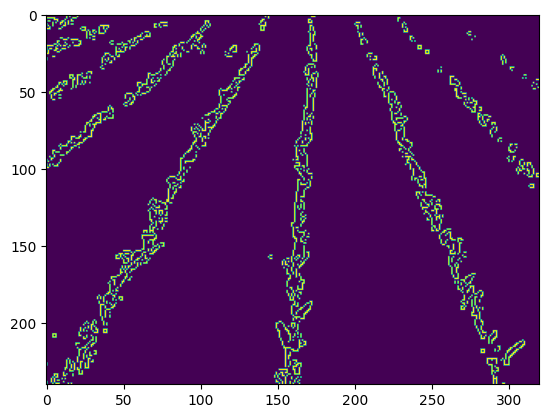

In [57]:
if(1): 
    imgs_folder = '/home/roxane/Desktop/M3_2022/Caterra/dataset_straigt_lines' # '/home/roxane/Desktop/M3_2022/USB/Realsense_18-08-2022_10-46-58/' 
    name_images = 'crop_row_211.JPG' #'rgb000.jpg' # crop_row_001, crop_row_020, crop_row_053
    sky_on = 0
    nb_row = 5
    vp_on = 1

    images = MaskingProcess.obtain_images(name_images,imgs_folder, 1)

    sky = sky_on
    """
    input : list of img to be analyzed in rgb format
    output : not yet defined, prob data + flag set to one if analyzing went smoothly 
    """
    imgs_annotated = []
    imgs_crops_only = []

    vp_pt = 0

    img = images[0]
    
    img_no_sky = img

    best_mask_median, best_mask_brut, col_best_mask = veg_segmentation(img, img_no_sky)

    #remove bushy regions 
    kernel = np.ones((2, 2), np.uint8)
    eroded = cv2.erode(best_mask_brut, kernel, iterations=1)
    best_mask = best_mask_brut-eroded

    best_mask_median_edge = cv2.Canny(best_mask_median,100,200)
    best_mask_brut_edge = cv2.Canny(best_mask_brut,100,200) 

    plt.imshow(best_mask_brut_edge)

step  1 of  6
90
step  2 of  6
87


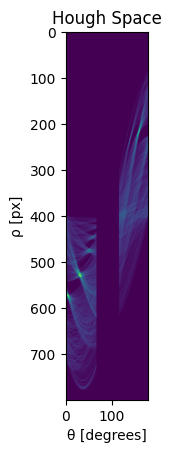

In [58]:
arr_mask, th_acc, r_acc, threshold_acc, best_mask_evaluate, pts1, pts2 = keep_mask_max_acc_lines(best_mask_brut_edge, img_no_sky, nb_row+1)


In [ ]:
def Initial_Process(img, nb_row = 4, sky = 0):

    #Cut off sky
    if(sky==1) : 
        grad_sky = MaskingProcess.get_sky_region_gradient(img)
        img_no_sky = MaskingProcess.cut_image_from_mask(grad_sky, img)
    else : 
        img_no_sky = img

    best_mask_median, best_mask_brut, col_best_mask = MaskingProcess.veg_segmentation(img, img_no_sky)

    #remove bushy regions 
    kernel = np.ones((2, 2), np.uint8)
    eroded = cv2.erode(best_mask_brut, kernel, iterations=1)
    best_mask = best_mask_brut-eroded

    best_mask_median_edge = cv2.Canny(best_mask_median,100,200)
    best_mask_brut_edge = cv2.Canny(best_mask_brut,100,200) 
    cv2.imshow('vegetation mask at the beginning', best_mask_brut_edge)
    cv2.waitKey(0)

    arr_mask, th_acc, r_acc, threshold_acc, best_mask_evaluate, pts1, pts2 = keep_mask_max_acc_lines(best_mask_brut_edge, img_no_sky, nb_row+1)


In [5]:
filename = '/home/roxane/Desktop/M3_2022/Caterra_2912/Caterra/imgannotated/img' + str(1)

In [6]:
filename

'/home/roxane/Desktop/M3_2022/Caterra_2912/Caterra/imgannotated/img1'

In [8]:
import cv2

In [9]:
img = cv2.imread('/home/roxane/Desktop/M3_2022/USB/Realsense_18-08-2022_10-46-58/rgb000.jpg')

In [12]:
idx = 0
filename = '/home/roxane/Desktop/M3_2022/Caterra_2912/Caterra/imgannotated/img_' + str(idx) + '.jpg'
print(filename)
cv2.imwrite(filename, img)

/home/roxane/Desktop/M3_2022/Caterra_2912/Caterra/imgannotated/img_0.jpg


True

In [50]:
import cv2
import os

# Create an VideoWriter object
# FourCC is a 4-byte code used to specify the video codec

fourcc = cv2.VideoWriter_fourcc(*'MJPG')

# Set up the frame rate and resolution of the output video
fps = 30
frame_size = (640, 480)



# The output video file name
output_file = '/home/roxane/Desktop/M3_2022/Caterra_2912/Caterra/full_process_vid.avi'
# Open a VideoWriter object
#out = cv2.VideoWriter(output_file, fourcc, fps, frame_size)

# Get the list of image files
image_files = os.listdir('/home/roxane/Desktop/M3_2022/Caterra_2912/Caterra/imgannotated/')
image_files = sorted(image_files)
image = cv2.imread(os.path.join('/home/roxane/Desktop/M3_2022/Caterra_2912/Caterra/imgannotated/', image_files[0]))
size = image.shape[:2]
out = cv2.VideoWriter(output_file,fourcc, 10, (size[1],size[0]))


# Iterate through the images and add them to the video
for idx, image_file in enumerate(image_files):
    # Load the image

    image = cv2.cvtColor(cv2.imread(os.path.join('/home/roxane/Desktop/M3_2022/Caterra_2912/Caterra/imgannotated/', image_file)), cv2.COLOR_BGR2RGB)
 
        
        # Add the image to the video
    out.write(image)

# Release the VideoWriter object
out.release()


In [69]:
from PIL import Image, ImageOps


def padding(img, expected_size):
    desired_size = expected_size
    delta_width = desired_size - img.size[0]
    delta_height = desired_size - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)


def resize_with_padding(img, expected_size):
    img.thumbnail((expected_size[0], expected_size[1]))
    # print(img.size)
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)




In [72]:
imgs = []
for idx, image_file in enumerate(image_files):
    img = (cv2.cvtColor(cv2.imread(os.path.join('/home/roxane/Desktop/M3_2022/Caterra_2912/Caterra/imgannotated/', image_file)), cv2.COLOR_BGR2RGB))
    img = Image.fromarray(img)
    img = resize_with_padding(img, (500, 180))
    img = np.asarray(img)
    imgs.append(img)


In [76]:
img.shape

(180, 500, 3)

In [77]:
import cv2
import os

# Create an VideoWriter object
# FourCC is a 4-byte code used to specify the video codec

fourcc = cv2.VideoWriter_fourcc(*'MJPG')

# Set up the frame rate and resolution of the output video
fps = 30
frame_size = (640, 480)



# The output video file name
output_file = '/home/roxane/Desktop/M3_2022/Caterra_2912/Caterra/full_process_vid.avi'
# Open a VideoWriter object
#out = cv2.VideoWriter(output_file, fourcc, fps, frame_size)

# Get the list of image files
image_files = os.listdir('/home/roxane/Desktop/M3_2022/Caterra_2912/Caterra/imgannotated/')
image_files = sorted(image_files)
image = img # cv2.imread(os.path.join('/home/roxane/Desktop/M3_2022/Caterra_2912/Caterra/imgannotated/', image_files[0]))
size = image.shape[:2]
out = cv2.VideoWriter(output_file,fourcc, 10, (size[1],size[0]))


# Iterate through the images and add them to the video
for idx, img in enumerate(imgs):
    # Load the image

        
        # Add the image to the video
    out.write(img)

# Release the VideoWriter object
out.release()


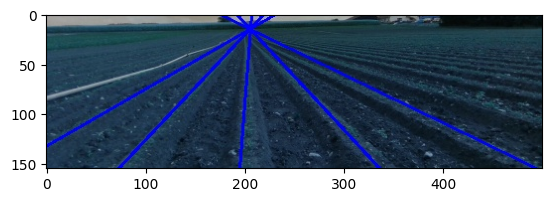

In [65]:
import numpy as np 

plt.imshow(imgs[300])
list_shape = []
for img in imgs:
    list_shape.append(img.shape[0])
list_shape = np.asarray(list_shape)

In [67]:
list_shape.max()

178

In [ ]:
from PIL import Image, ImageOps


def padding(img, expected_size):
    desired_size = expected_size
    delta_width = desired_size - img.size[0]
    delta_height = desired_size - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)


def resize_with_padding(img, expected_size):
    img.thumbnail((expected_size[0], expected_size[1]))
    # print(img.size)
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)


if __name__ == "__main__":
    img = Image.open("./demo.jpg")
    print(img)
    img = resize_with_padding(img, (500, 400))
    print(img.size)
    img.show()
    img.save("resized_img.jpg")

In [22]:
import matplotlib.pyplot as plt

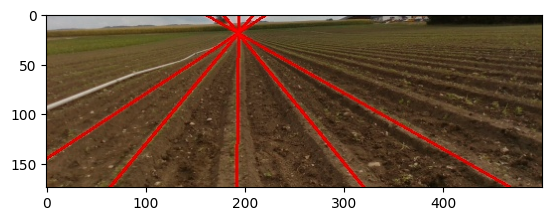

In [35]:
plt.imshow(image)

In [80]:
import cv2
import os

# Folder containing the images
folder = "/home/roxane/Desktop/M3_2022/Caterra_2912/Caterra/imgannotated"

# Create a VideoCapture object
cap = cv2.VideoCapture(0)

# Determine the width and height of the images in the folder
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Set the width and height of the images to be padded
pad_width = width
pad_height = height

# Create a VideoWriter object for saving the video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('video.mp4', fourcc, 10.0, (width, height))

# Loop through all the images in the folder
for file in sorted(os.listdir(folder)):
    # Read the image
    img = cv2.imread(os.path.join(folder, file))
    
    # Determine the height and width of the image
    img_height, img_width, _ = img.shape
    
    # Calculate the padding needed for the image
    top_pad = (pad_height - img_height) // 2
    bottom_pad = pad_height - img_height - top_pad
    left_pad = (pad_width - img_width) // 2
    right_pad = pad_width - img_width - left_pad
    
    # Pad the image with zeros
    padded_img = cv2.copyMakeBorder(img, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT, value=0)
    
    # Write the padded image to the output video
    out.write(padded_img)

# Release the VideoWriter and VideoCapture objects
out.release()
cap.release()


In [82]:
folder = "/home/roxane/Desktop/M3_2022/Caterra_2912/Caterra/imgannotated"
imgs = []

for file in sorted(os.listdir(folder)):
    imgs.append(cv2.imread(os.path.join(folder, file)))



In [90]:
imgs_resize = []
h_min = 1000
for img in imgs:
    h = img.shape[0]
    if (h<h_min):
        h_min = h
    img = img[h-134:, :, :]
    imgs_resize.append(img)
    #print(h)
    #img = [h-134:,]

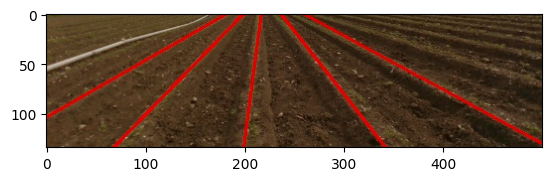

In [93]:
import cv2
import os


cap = cv2.VideoCapture(0)

# Determine the width and height of the images in the folder
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Set the width and height of the images to be padded
pad_width = width
pad_height = height

# Create a VideoWriter object for saving the video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('video.mp4', fourcc, 10.0, img.shape[:1])

# Loop through all the images in the folder
for img in img_resize:

    img_height, img_width, _ = img.shape
    
    out.write(padded_img)

# Release the VideoWriter and VideoCapture objects
out.release()


In [97]:
import cv2
import os

# Create an VideoWriter object
# FourCC is a 4-byte code used to specify the video codec

fourcc = cv2.VideoWriter_fourcc(*'MJPG')

# Set up the frame rate and resolution of the output video
fps = 30
frame_size = imgs_resize[0].shape[:1]



# The output video file name
output_file = '/home/roxane/Desktop/M3_2022/Caterra_2912/Caterra/full_process_vid2.avi'
# Open a VideoWriter object
#out = cv2.VideoWriter(output_file, fourcc, fps, frame_size)

# Get the list of image files
image_files = os.listdir('/home/roxane/Desktop/M3_2022/Caterra_2912/Caterra/imgannotated/')
image_files = sorted(image_files)
image = imgs_resize[0] # cv2.imread(os.path.join('/home/roxane/Desktop/M3_2022/Caterra_2912/Caterra/imgannotated/', image_files[0]))
size = image.shape[:2]
out = cv2.VideoWriter(output_file,fourcc, 5, (size[1],size[0]))


# Iterate through the images and add them to the video
for idx, img in enumerate(imgs_resize):
    # Load the image

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Add the image to the video
    out.write(img_rgb)

# Release the VideoWriter object
out.release()

In [103]:
size = imgs_resize[0].shape[:2]
print(size)

(134, 500)


In [107]:
import cv2
import numpy as np
import glob

image = imgs_resize[0]
size = image.shape[:2]
print(size)
fourcc = cv2.VideoWriter_fourcc(*'MJPG')

out = cv2.VideoWriter(output_file,fourcc, 10, (size[1],size[0]))

#out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(imgs_resize)):
    #print(np.shape(imgs_resize[i]))
    out.write(imgs_resize[i])
out.release()

(134, 500)


In [114]:
import cv2
import os

# Create an VideoWriter object
# FourCC is a 4-byte code used to specify the video codec

fourcc = cv2.VideoWriter_fourcc(*'MJPG')

# Set up the frame rate and resolution of the output video
fps = 30
frame_size = (640, 480)



# The output video file name
output_file = '/home/roxane/Desktop/M3_2022/Caterra_2912/Caterra/full_process_vid3.avi'
# Open a VideoWriter object
#out = cv2.VideoWriter(output_file, fourcc, fps, frame_size)

# Get the list of image files
image_files = os.listdir('/home/roxane/Desktop/M3_2022/Caterra_2912/Caterra/imgannotated/')
image_files = sorted(image_files)
image = imgs_resize[0]#cv2.imread(os.path.join('/home/roxane/Desktop/M3_2022/Caterra_2912/Caterra/imgannotated/', image_files[0]))
size = image.shape[:2]
out = cv2.VideoWriter(output_file,fourcc, 1, (size[1],size[0]))


# Iterate through the images and add them to the video
for idx, image in enumerate(imgs_resize):
    # Load the image

    #image = cv2.cvtColor(cv2.imread(os.path.join('/home/roxane/Desktop/M3_2022/Caterra_2912/Caterra/imgannotated/', image_file)), cv2.COLOR_BGR2RGB)
 
        
        # Add the image to the video
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if (idx<365):
        out.write(img_rgb)

# Release the VideoWriter object
out.release()


In [116]:
result = str(3).zfill(3)
print(result)

003
